# Fits and Data Analysis
---
* Analysing and fitting Data (usage of scipy)
* Visualisation of fits
* Basics of Classification

#### Create a function for fast plotting to rapidly check/visualize some data

In [106]:
import matplotlib.pyplot as plt

# needed only in jupyter and this session ---
# please ignore the following 3 lines
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'DejaVu Sans','size': 20})

def fast_plot(x, y, xlabel="x", ylabel="y"):
    """
    Function for plotting y vs x as points
        optional arguments are the axis labels
    """
    
    fig, ax = plt.subplots()
    ax.plot(x, y, ".")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()

## Basics of fitting

Lets generate a linear relationship with some noise and fit a function to it

In [107]:
import numpy as np

# create a random linear dataset
N = 100
x = np.linspace(0, 1, N)
randnr = np.random.rand(N)
y = - x + 2.0 + (randnr*0.5)

Now lets check that the created linear relationship has indeed a decaying behaviour

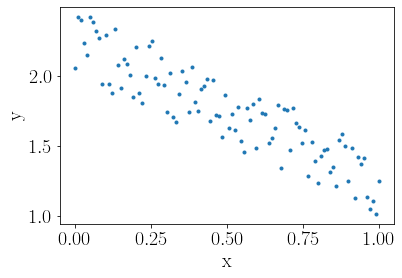

In [108]:
fast_plot(x, y)

### Fitting the data

Here we generated both the x and the y values. Usually when fitting the latter represent the dependent variable which we would like to fit.

The first step is to understand what function we would like to fit to y. In this case it a linear slope. We thus create such a function with some unknown coefficients $a$ and $c$: $f(x) = a x + c$

In [109]:
def fitting_lin_slope(x, a, c):
    return a * x + c

Now we load an additional library that is built upon `numpy` and is specifically designed for scientific computing. We don't load the entire library, but only the fitting function we need

In [11]:
from scipy.optimize import curve_fit

`curve_fit()` is a function that, as the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) tells us, uses "non-linear least squares to fit a function, f, to data".

In other words: we have to give `curve_fit` a function (which we assume will fit our data), the independet values of x and the dependent values of y.

The output will be twofold: 
* on one side we have an array with the optimal values for the coefficients of our function (in this case $a$ and $c$)
* on the other we get a matrix with the covariance values of the optimized coefficients, from which we can the compute the standard deviation taking the square root of the diagonal elements.


In [12]:
    # optimize function coefficients | test bounds=([-1,0], [0,2])
opt_vals, cov_coeff = curve_fit(fitting_lin_slope, x, y)

print("optimal a = {}\noptimal c = {}\n\nstd of a = {}\nstd of c = {}".
      format(opt_vals[0], opt_vals[1], *np.sqrt(np.diag(cov_coeff))))

optimal a = -0.9586498630579081
optimal c = 2.2426593539595956

std of a = 0.051329855791388566
std of c = 0.02971004845631293


as we can see the optimal $a$ is indeed close to $-1$ and the optimal $c$ is close to $2.25$ as we defined them in our generating relationship

__note__: for a list `l = [0,1,2,3,4, ... , n]` writing `*l` is equivalent to writing `l[0], l[1], l[2], ... ,l[n]`. We are going to use this notation more often in the following

---
Now lets visualize the data with its fit. To do so it is now very convenient that we defined the fitting function, since we can now use this to generate the fitting slope

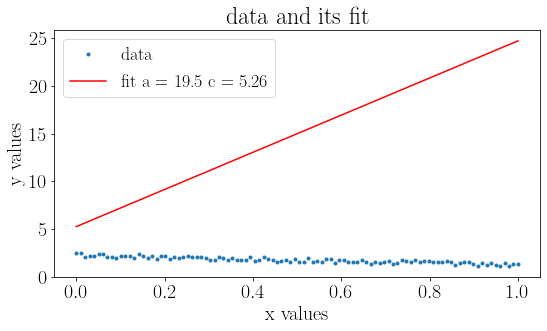

In [105]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout = True)

text_label_fit = "fit a = {:.3} c = {:.3}".format(*opt_vals)

ax.plot(x, y, ".", label="data")
ax.plot(x, fitting_lin_slope(x, *opt_vals), "r-", label = text_label_fit)

ax.legend(fontsize=18)

ax.set_xlabel("x values")
ax.set_ylabel("y values")

ax.set_title("data and its fit")

fig.show()

## Gaussian fit to distribution

---

Now lets see another very common fit: the Gaussian fit.

For every distribution you find, you might want to fit a Gaussian distribution to some data

From the a [machine learning repository](https://archive.ics.uci.edu/ml/index.php) we can take the data about forest fires. (as you see the `read_csv()` method of pandas is able to get data als from online links)

In [39]:
import pandas as pd

fires = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv', 
                   index_col=0)

fires

,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,,,,,,,,,,,,
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16


This dataframe now contains a lot of interesting data (and a little bit more than before with the populations and the brain sizes) to be analised.

As we will see, the temperature is has a distribution of the data that mostly resembles a Gaussian, we therefore want to fit this distribution.

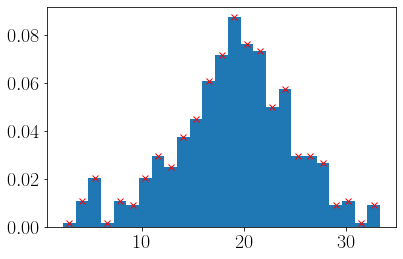

In [72]:
# save temperature data to one array
temps = fires.temp

binnr = 25

# check with a plot the histogram and save the histogram values
fig, ax = plt.subplots(1,1, tight_layout = True)

vals, binedge, handle = ax.hist(temps, bins=binnr, density=True)

# to overcome wrong positioning of the bins, compute the width of one bin and subtract half of it it to the edges
# bin_width = binedge[1] - binedge[0]

# - bin_width/2
bincenter = binedge[1:]

# plot maxima of the values
ax.plot(bincenter, vals, "rx")

fig.show()

here we rapidly checked the values of the temperature as a histogram with 25 bins and saved the variables of the histogram and the bin edges to two variables.

This could have been done also separately with the according [numpy histogram function](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html#numpy.histogram).

__note__: that the output of the `hist()` function are the values of the histogram and the binedges, meaning an array of the length $binnr + 1$. We thus have to compute the bincenters with the width of the bins.

Now we can create a function for the Gaussian distribution (refer e.g. to the [wikipedia page](https://en.wikipedia.org/wiki/Gaussian_function))

In [67]:
def gaussian(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi))*np.exp(- ((x - mu)**2)/(2*sigma**2) ))

In [125]:
# fit the gaussian to the values of the histogram
opt_vals, cov_coeff = curve_fit(gaussian, bincenter, vals)

print("optimal expected value mu: {}\noptimal standar deviation sigma: {}".format(*opt_vals))

optimal expected value mu: 19.45990838629157
optimal standar deviation sigma: 5.259990630777888


In [99]:
gauss_fit

array([0.0005097 , 0.00104727, 0.00203473, 0.00373823, 0.00649432,
       0.01066866, 0.01657273, 0.02434372, 0.03381335, 0.04441176,
       0.05515897, 0.06478027, 0.07194123, 0.07554773, 0.07501937,
       0.07044236, 0.06254647, 0.05251461, 0.04169327, 0.03130115,
       0.02222097, 0.01491675, 0.00946878, 0.00568358, 0.00322596])

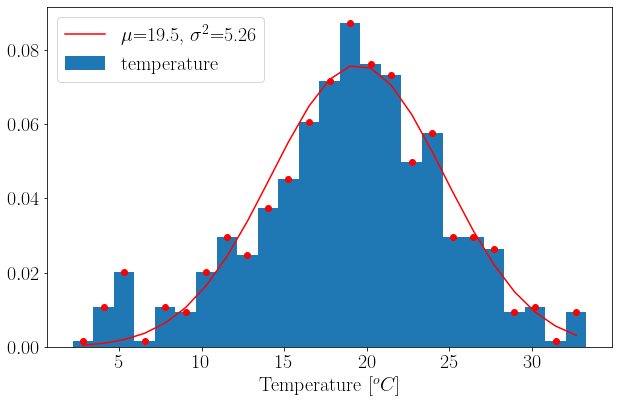

In [147]:
# plot everything

mu, sigma = opt_vals[0], opt_vals[1]
gauss_fit = gaussian(bincenter, *opt_vals)
max_gauss = max(gauss_fit)

fig, ax = plt.subplots(1,1, figsize=(9,6), tight_layout=True)

ax.hist(temps, bins=binnr, density=True, label="temperature")
ax.plot(bincenter, vals, "ro")

label_text="$\mu$={:.3}, $\sigma^2$={:.3}".format(*opt_vals)
ax.plot(bincenter, gauss_fit, 'r-', label=label_text)

ax.set_xlabel("Temperature [$^oC$]")
ax.legend()

# # find value for half max gauss
# half_max_idx = np.abs(gauss_fit - max_gauss/2).argmin()
# print(bincenter[half_max_idx])
# starting_bin = bincenter[half_max_idx]
# if starting_bin < mu:
#     xmin, xmax = starting_bin, starting_bin + 2*sigma
# else:
#     xmax, xmin = starting_bin, starting_bin - 2*sigma

# # plot mu and sigma
# ax.vlines(x=mu, color="grey", linestyle="--", ymin=0, ymax=max_gauss)
# ax.hlines(y=max_gauss/2, xmin=xmin, xmax=xmax, color="grey", linestyle="--")

fig.show()

a

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv', 
                   index_col=0)


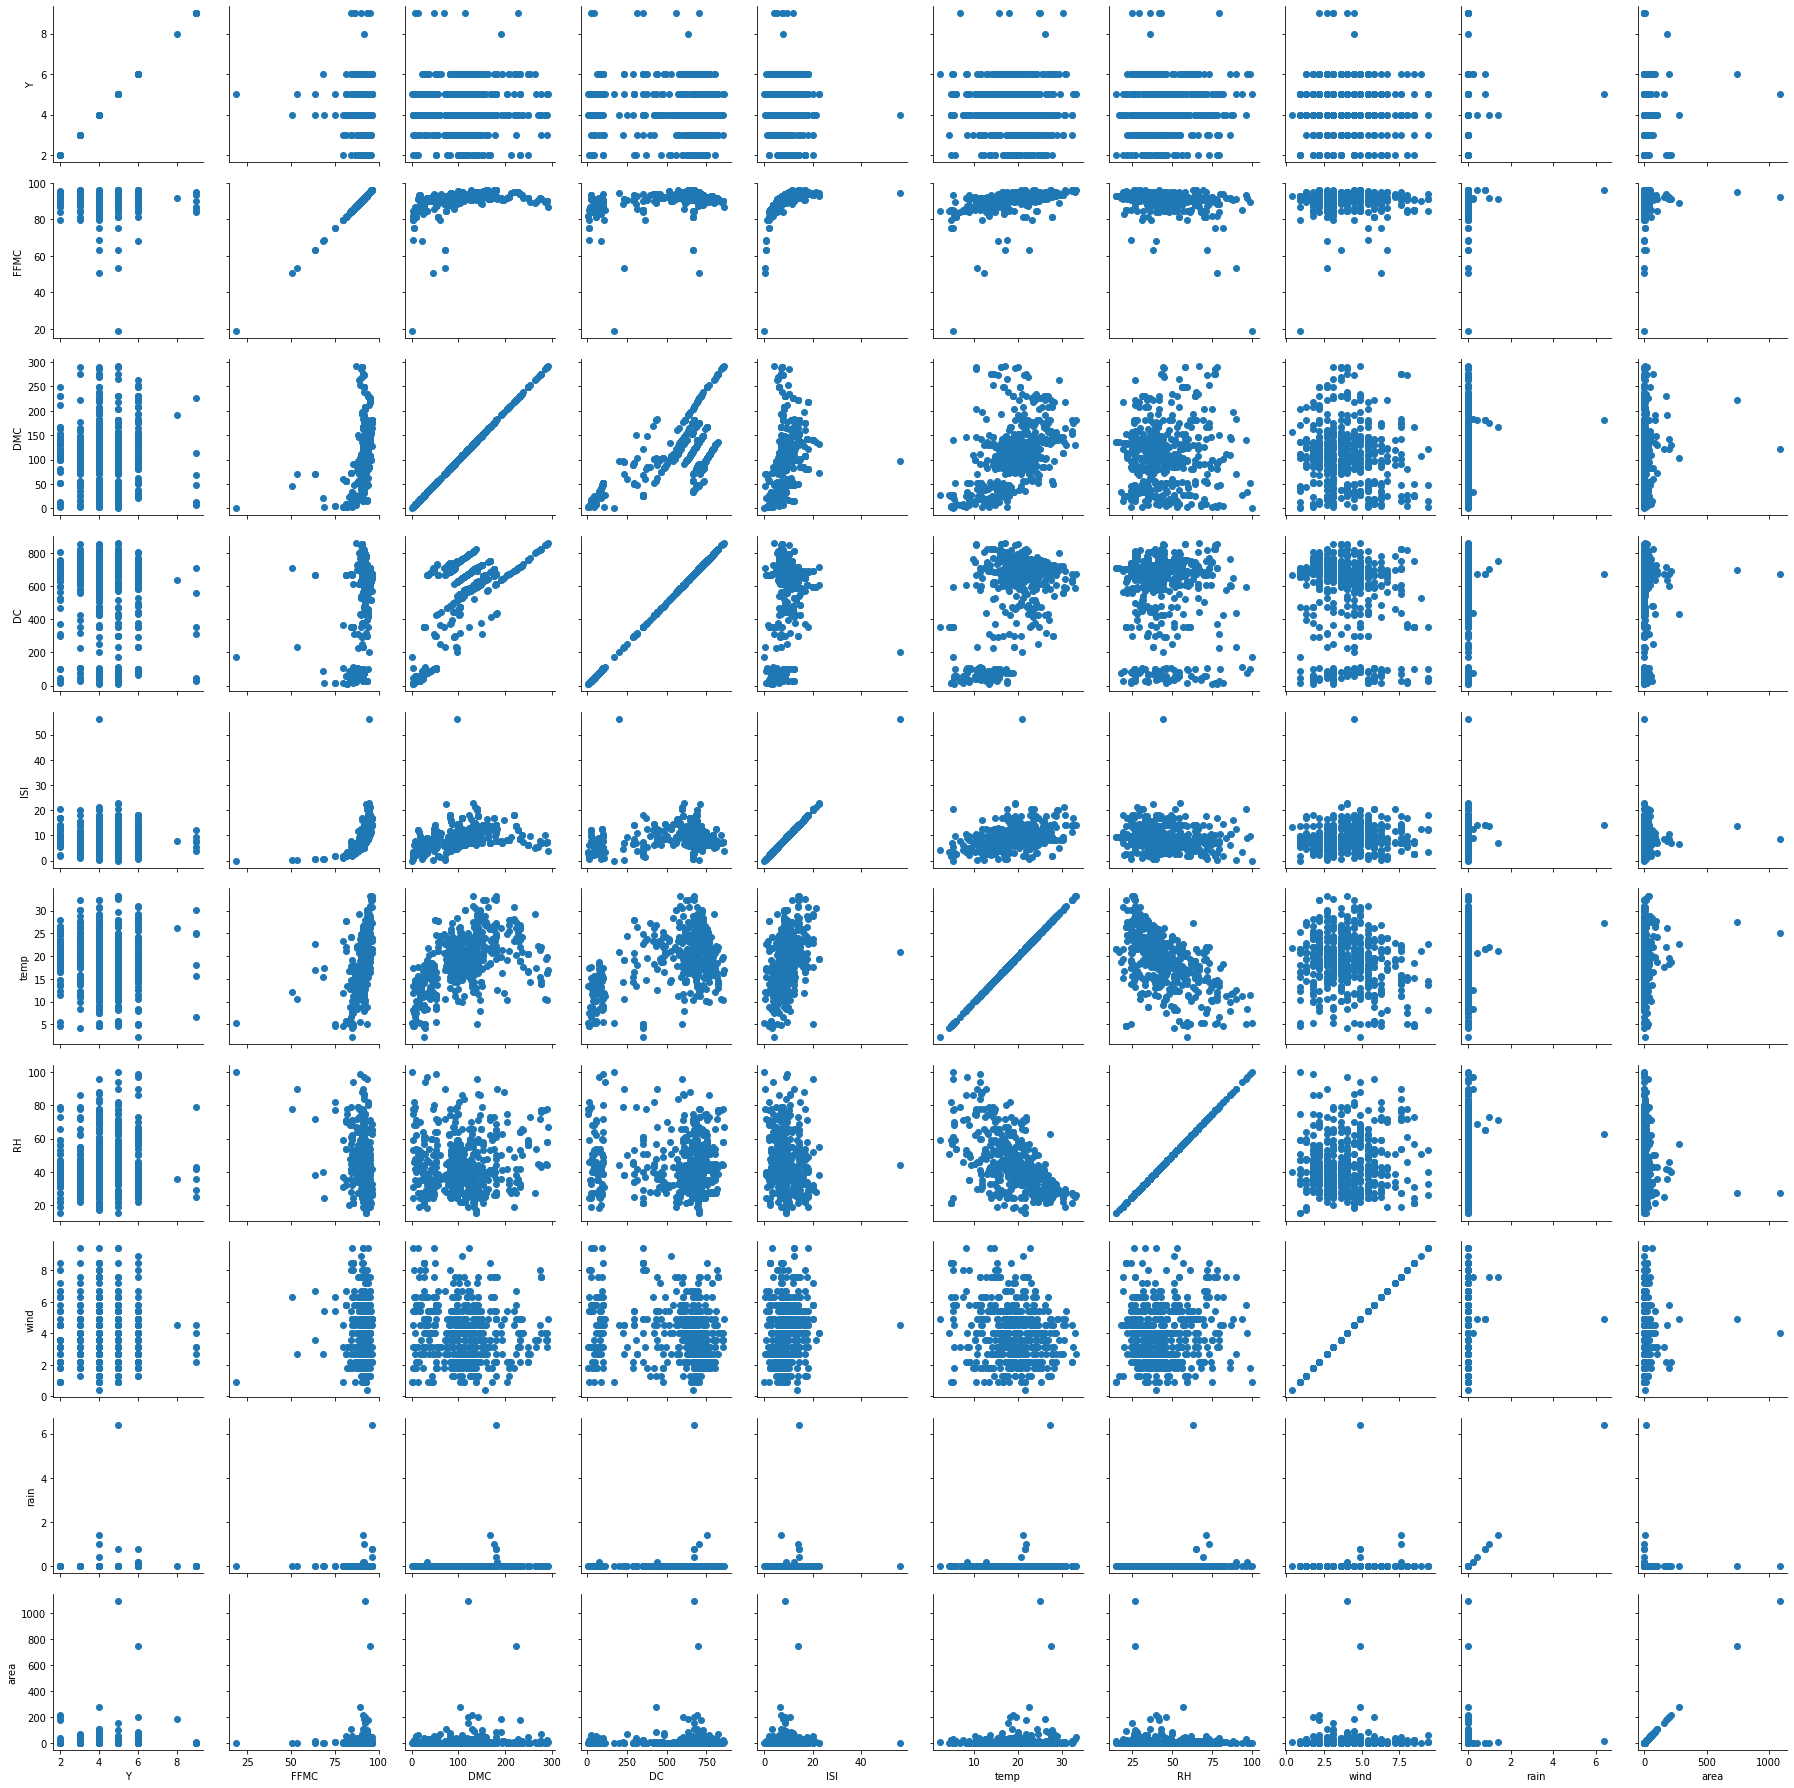

In [14]:
import seaborn as sns


g = sns.PairGrid(data)
g.map(plt.scatter)

(array([ 1.,  7., 13.,  1.,  7.,  6., 13., 19., 16., 24., 29., 39., 46.,
        56., 49., 47., 32., 37., 19., 19., 17.,  6.,  7.,  1.,  6.]),
 array([ 2.2  ,  3.444,  4.688,  5.932,  7.176,  8.42 ,  9.664, 10.908,
        12.152, 13.396, 14.64 , 15.884, 17.128, 18.372, 19.616, 20.86 ,
        22.104, 23.348, 24.592, 25.836, 27.08 , 28.324, 29.568, 30.812,
        32.056, 33.3  ]),
 <a list of 25 Patch objects>)

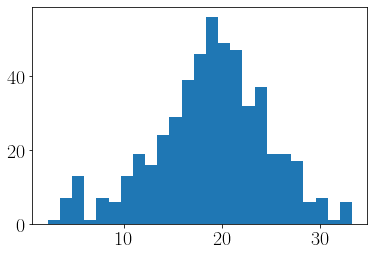

In [47]:
plt.hist(data.temp, bins=25)

## Assignments
---
* Create an exponentially decaying relationship with some noise and fit it using first a linear slope function and then an exponential function. Compare and comment on the covariance/standar deviation.
* Create a function for automatising the Gaussian fit and eventually add it to a class. Test it on different variables of the forest fires data